In [120]:
# Imports

# File handling
import os
import cv2
import splitfolders

# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NumPy
import numpy as np

# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from keras import models, layers
import keras_tuner as kt
from keras.callbacks import CSVLogger
from keras.utils import image_dataset_from_directory
from keras.regularizers import l2

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from imblearn.metrics import sensitivity_score

## Utility functions

In [87]:
def load_model(file="model.h5", hist="training.log"):
    
    # load model and history
    
    import tensorflow as tf
    import pandas as pd
    import numpy as np
    model = tf.keras.models.load_model(file)
    history = pd.read_csv(hist)[['loss','binary_accuracy', 'val_loss', 'val_binary_accuracy']]
    return model, history

def get_data(train_path='images/train/', test_path='images/test/', valid_path='images/val/'):
    
    # preprocess train, test and valid sets
    
    from keras.utils import image_dataset_from_directory
    train = image_dataset_from_directory(directory=train_path,
                             label_mode='binary',
                             color_mode="rgb",
                             image_size=(256, 256),
                             shuffle=True,
                             seed=77)
    test = image_dataset_from_directory(directory=test_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=(256, 256))
    valid = image_dataset_from_directory(directory=valid_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=(256, 256))
    return train, test, valid

def evaluate_model(model, valid, test):
    
    pd.read_csv('training.log')[['binary_accuracy','loss','val_binary_accuracy','val_loss']].plot(figsize=(15,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Model Learning Curves')
    plt.show()
    print()
    print()
    print()
    print('Test set score')
    print()
    model.evaluate(test)
    print()
    print()
    print()
    print('Validation set score')
    print()
    model.evaluate(valid)

def dim_info(dimension):
    print("Dimension type: ", type(dimension))
    print("Dimension length: ", len(dimension))

def images_to_arrays_X_y(folder_path):
    X = []
    y = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_label = class_folder  # assign class folder name as label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (256, 256))  # resize
                img_array = np.array(img, dtype=np.float32)  # convert array values to float
                X.append(img_array)
                y.append(class_label)
    return np.array(X), np.array(y)

def images_to_arrays(folder_path):
    data = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_label = class_folder  # assign class folder name as label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (256, 256))  # resize
                img_array = np.array(img, dtype=np.float32)  # convert array values to float
                data.append([img_array,class_label])
    return data

In [88]:
# load model and history
model, history = load_model("model.h5")

In [ ]:
# data
train, test, valid = get_data()

## Model

In [7]:
# cnn model
shape = (256, 256, 3)
drop = 0.5
kernel = 2
pool = 2
regularizer=l2(0.01)
learning_rate=0.0017

model = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer 1
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer 2
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

In [8]:
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0

In [11]:
csv_logger = CSVLogger('training.log')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="training_1/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[csv_logger, early_stopping_cb, cp_callback])

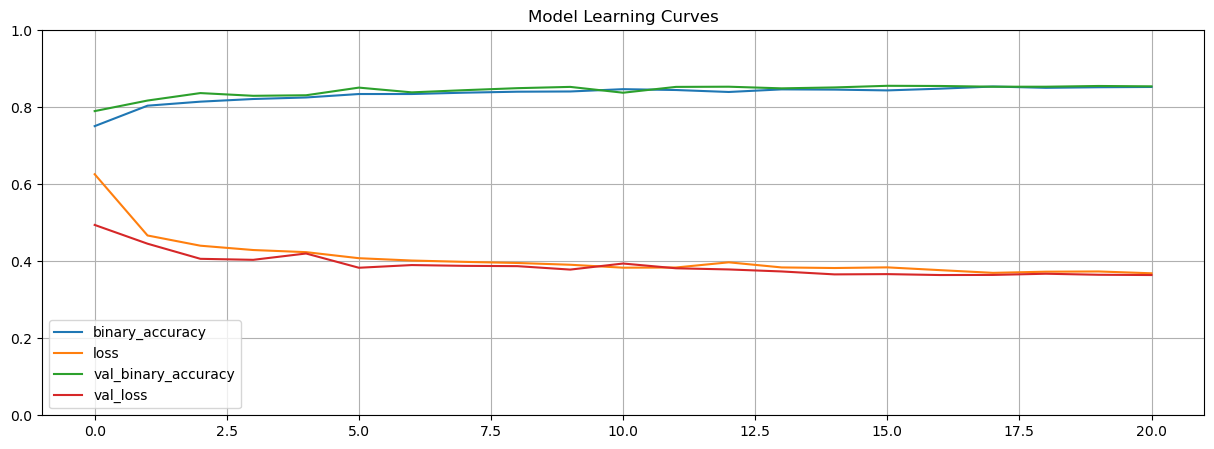




Test set score

67/67 [==============================] - 5s 71ms/step - loss: 0.3563 - binary_accuracy: 0.8637



Validation set score

67/67 [==============================] - 5s 70ms/step - loss: 0.3643 - binary_accuracy: 0.8553


In [31]:
evaluate_model(model)

In [109]:
X_test, y_test = images_to_arrays_X_y("images\\test")
y_test[y_test == 'healthy'] = 0
y_test[y_test == 'sick'] = 1
y_test = y_test.astype('float32')
pred = model.predict(X_test).round()

67/67 [==============================] - 4s 60ms/step


In [127]:
print("Sensitivity score: ", sensitivity_score(y_test, pred))

Sensitivity score:  0.8481818181818181


In [110]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      1020
         1.0       0.88      0.85      0.87      1100

    accuracy                           0.86      2120
   macro avg       0.86      0.86      0.86      2120
weighted avg       0.86      0.86      0.86      2120



## Sensitivity analysis

In [39]:
# covolutional layers and dropout layer
important_layers = [model.layers[2], model.layers[4], model.layers[7]]
layer_outputs_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in important_layers])
sample_input = X_test
layer_outputs = layer_outputs_model.predict(sample_input)

1/1 [==============================] - 0s 52ms/step


In [40]:
# conv2d layer 1 output before adding change
layer1_before = sum(sum(sum(sum(abs(layer_outputs[0])))))

# conv2d layer 2 output before adding change
layer2_before = sum(sum(sum(sum(abs(layer_outputs[1])))))

# dropout layer output before adding change
layer3_before = sum(sum(abs(layer_outputs[2])))

In [46]:
# perturbation magnitude
perturbation = 0.01

# perturbation analysis for each layer
for i, layer_output in enumerate(layer_outputs):
    
    # create a copy of the layer output for perturbation
    perturbed_output = layer_output.copy()

    # perturb the layer output by adding noise
    noise = np.random.normal(loc=0, scale=perturbation, size=layer_output.shape)
    perturbed_output += noise

    # replace the layer output with the perturbed output
    layer_outputs[i] = perturbed_output

In [48]:
# conv2d layer 1 output after adding change
layer1_after = sum(sum(sum(sum(abs(layer_outputs[0])))))

# conv2d layer 2 output after adding change
layer2_after = sum(sum(sum(sum(abs(layer_outputs[1])))))

# dropout layer output after adding change
layer3_after = sum(sum(abs(layer_outputs[2])))

In [62]:
# differences between before/after perturbation output values
layer1_difference = abs((layer1_after - layer1_before)) /layer1_before
layer2_difference = abs((layer2_after - layer2_before)) /layer2_before
layer3_difference = abs((layer3_after - layer3_before)) /layer3_before

In [97]:
before_output = pd.Series([layer1_before, layer2_before, layer3_before])
after_output = pd.Series([layer1_after, layer2_after, layer3_after])
percentage_difference = pd.Series([layer1_difference, layer2_difference, layer3_difference])
layer = pd.Series(['conv2d','conv2d_1','dropout'])

cnn_sensitivity_analysis = pd.DataFrame(data = [layer, before_output, after_output, percentage_difference]).transpose()
cnn_sensitivity_analysis.columns = ['layer','before_output','after_output','percentage_difference']
cnn_sensitivity_analysis

,layer,before_output,after_output,percentage_difference
0,conv2d,9180.2626,17088.043938,0.861389
1,conv2d_1,984.09481,2778.430855,1.823337
2,dropout,317.976129,754.820912,1.373829


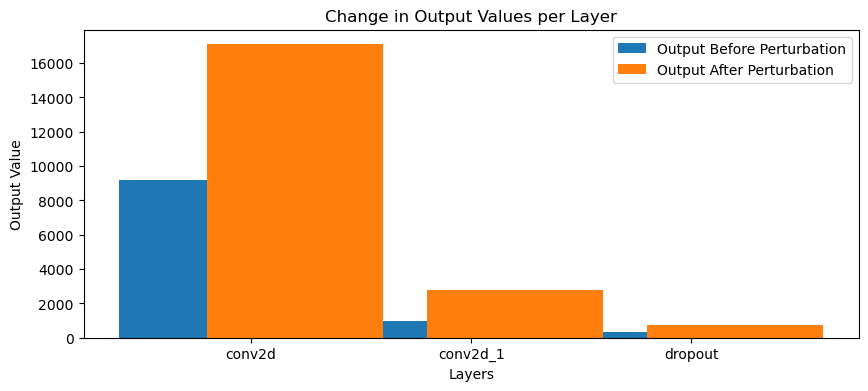

In [117]:
X_axis = np.arange(len(layer))
plt.figure(figsize=(10,4))
plt.bar(X_axis - 0.2, before_output, label="Output Before Perturbation")
plt.bar(X_axis + 0.2, after_output, label="Output After Perturbation")

plt.xticks(X_axis, layer)
plt.xlabel("Layers")
plt.ylabel("Output Value")
plt.title("Change in Output Values per Layer")
plt.legend()
plt.show()

## Other classification Models

In [123]:
# data preprocessing
X_train, y_train = images_to_arrays_X_y("images\\train")
y_train[y_train == 'healthy'] = 0
y_train[y_train == 'sick'] = 1
y_train = y_train.astype('float32')

X_test, y_test = images_to_arrays_X_y("images\\test")
y_test[y_test == 'healthy'] = 0
y_test[y_test == 'sick'] = 1
y_test = y_test.astype('float32')

# input
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [124]:
# logistic regression classifier
logreg = LogisticRegression(max_iter=50)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)

In [125]:
print("Logistic Regression Classifier accuracy: ", logreg.score(X_test_flat, y_test))
print("Sensitivity score: ", sensitivity_score(y_test, y_pred_logreg))

Logistic Regression Classifier accuracy:  0.8160377358490566
Sensitivity score:  0.8245454545454546


In [43]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      1020
         1.0       0.82      0.82      0.82      1100

    accuracy                           0.82      2120
   macro avg       0.82      0.82      0.82      2120
weighted avg       0.82      0.82      0.82      2120



In [126]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)
print("K-Nearest-Neighbour Classifier accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Sensitivity score: ", sensitivity_score(y_test, y_pred_knn))

K-Nearest-Neighbour Classifier accuracy:  0.8537735849056604
Sensitivity score:  0.850909090909091


In [47]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1020
         1.0       0.87      0.85      0.86      1100

    accuracy                           0.85      2120
   macro avg       0.85      0.85      0.85      2120
weighted avg       0.85      0.85      0.85      2120

